# Tracking the Cyclonic eddy sampled during the OTC23 course

This notebook is a part of the Ocean Training Course 2023, Working Group 2. It's main goal is to select and characterize the _life_ of two eddies sampled during the on board session.

<div class="alert alert-warning">
    <strong>To run this notebook, you will need:</strong>
    
* A directory `obs_datadir` with the a collection of cyclonic eddy detection files written by py-eddy-tracker library. For instance, using the python script _"../scripts/eddy-identification.py"_
* A directory `gos_datadir` where the CMEMS altimetry datasets are stored
* Fill the three dictionnaries `c_eddy1_end`, `c_eddy2_end` and `merged_start`: each of these define a point (lat,lon,time) needed to extract the desired trajectories from all
</div>

### User options

In [1]:
# I/O options
obs_datadir = r'../../observations/SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046/adt/'
gos_datadir = r'../../datas/cmems/'
gos_product = 'SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046'
load_json   = False

# Tracks detection
merged_start = {'lon': 30.2, 'lat': -34.6, 'time': 26669.}
c_eddy1_end  = {'lon': 34.7, 'lat': -33.8, 'time': 26539.}
c_eddy2_end  = {'lon': 35.1, 'lat': -32.6, 'time': 26539.}

# logger type
logger_type = 'ERROR'   # (py-eddy-tracker) Available options: ERROR, WARNING, INFO, DEBUG

In [2]:
# Constants
earth_radius = 6371229.

### Import necessary modules

In [51]:
import glob
import json
import os
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.path import Path
from shapely.geometry.polygon import LinearRing

from py_eddy_tracker import start_logger
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.tracking import Correspondances

start_logger().setLevel(logger_type)

### function definition

In [4]:
def select_closest_track(eddies, lon, lat, time=None):
    """select a track which pass close to a lon,lat point."""
    
    if time is None:
        nan_mask = np.ones_like(eddies.amplitude)
    else:
        cnd_time = (eddies.time == time)
        nan_mask = np.where(cnd_time, 1., np.nan)

    distance = ((eddies.lon - lon)**2. + (eddies.lat - lat)**2.)**0.5
    distance *= nan_mask

    obsindex = np.nanargmin(distance)
    track_id = eddies.tracks[obsindex]

    track    = eddies.extract_ids([track_id])
    
    return track

def to_datetime(days):
    """convert a number of days after 1950-01-01 to the equivalent datetime"""
    
    return datetime(1950, 1, 1) + days * timedelta(days=1)


## 1. Focus on the cyclonic eddy formation

In [5]:
# First, select the cyclonic eddies track (before and after merging)
# -- all the files in 'obs_datadir' will be loaded
list_files = glob.glob(os.path.join(obs_datadir, '*'))

c = Correspondances(datasets=sorted(list_files[:]), class_method=AreaTracker, virtual=3)
c.track()
c.prepare_merging()

# -- here, we get a collection of eddies
tracked = c.merge(raw_data=False)
tracked.virtual[:] = tracked.time == 0
tracked.filled_by_interpolation(tracked.virtual == 1.)

# -- select a track which pass close to a lon,lat,time point
c_mrged_track = select_closest_track(tracked, **merged_start)
c_eddy1_track = select_closest_track(tracked, **c_eddy1_end)
c_eddy2_track = select_closest_track(tracked, **c_eddy2_end)

In [6]:
# Load syntool extracted track (can be used for comparison/validation)
syn_lons = list()
syn_lats = list()
    
if load_json:
    list_syn = glob.glob(os.path.join(obs_datadir, '../../*.json'))

    for synf in sorted(list_syn):
        with open(synf, 'r') as f:
            user_shape = json.load(f)[0]

        syn_lons.append(user_shape['center'][0])
        syn_lats.append(user_shape['center'][1])

In [7]:
# Load altimetry datasets
list_gos = glob.glob(os.path.join(gos_datadir, gos_product, '*.nc'))
ds       = xr.open_mfdataset(list_gos).load()

### Plot eddy trajectories

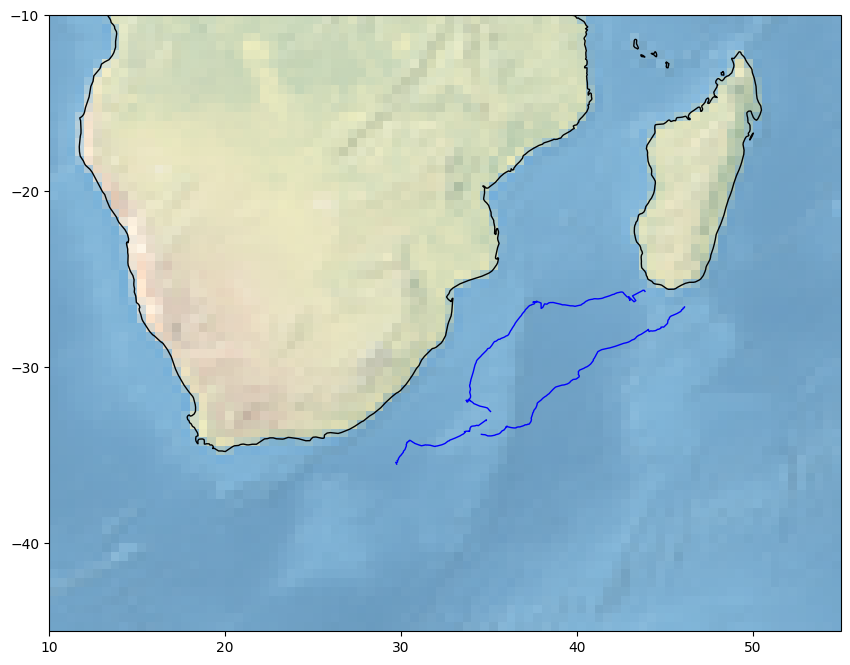

In [54]:
# Plot the eddy tracks
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([10, 55, -45, -10], crs=ccrs.PlateCarree())

# -- background image on for nice sea rendering
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

ax.set_xticks([10, 20, 30, 40, 50])
ax.set_yticks([-40, -30, -20, -10])

# -- add eddy track
c_mrged_track.plot(ax, color="b", lw=1)
c_eddy1_track.plot(ax, color="b", lw=1)
c_eddy2_track.plot(ax, color="b", lw=1)

# -- add eddy contours
#ax.plot(c_mrged_track.speed_contour_longitude[0],   c_mrged_track.speed_contour_latitude[0])
#ax.plot(c_eddy1_track.speed_contour_longitude[-1],  c_eddy2_track.speed_contour_latitude[-1],  'orange')
#ax.plot(c_eddy2_track.speed_contour_longitude[-1],  c_eddy1_track.speed_contour_latitude[-1],  'orange')
#ax.plot(c_mrged_track.speed_contour_longitude[-33], c_mrged_track.speed_contour_latitude[-33], 'green')

# -- add sea level anomaly colormesh
#glon, glat = np.meshgrid(ds['longitude'], ds['latitude'])
#ax.pcolormesh(glon, glat, ds['sla'][-1], cmap='bwr')

# -- add syntool tracks (manually exported in json files)
if load_json:
    ax.scatter(manlons[-1], manlats[-1], c="blue", s=5e0, alpha=0.75)

# -- plot/save figure
#fig.savefig('./cyclonic_eddy_tracked.png', dpi=300)

plt.show()

### Compute the eddy kinetic energy (EKE)

In [9]:
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker import data
from py_eddy_tracker.poly import create_vertice

g = RegularGridDataset(
    list_gos[0],
    "longitude",
    "latitude",
)

In [10]:
# First, compute EKE
ds['eke']       = 0.5*(ds['ugosa']*ds['ugosa'] + ds['vgosa']*ds['vgosa'])
ds['eke'].attrs = {'comment': 'Eddy Kinetic Energy computed from geostrophic velocity anomalies over the '
                              '[1993 to 2012] period',
                   'grid_mapping': 'crs',
                   'long_name': 'Surface eddy kinetic energy',
                   'standard_name': 'surface_eddy_kinetic_energy_from_geostrophic_velocity_anomalies',
                   'units' : 'm2/s2',
                  }

In [11]:
# Then, compute dx, dy needed for cell surfaces
glon, glat   = np.meshgrid(ds['longitude'], ds['latitude'])

dlon         = np.zeros(ds['longitude'].shape)
lon_bnds     = 0.5*(ds['longitude'][:-1].data + ds['longitude'][1:].data) 
dlon[1:-1]   = lon_bnds[1:] - lon_bnds[:-1]
dlon[0]      = 2 * (lon_bnds[0] - ds['longitude'][0])
dlon[-1]     = 2 * (ds['longitude'][-1] - lon_bnds[-1])

dlat         = np.zeros(ds['latitude'].shape)
lat_bnds     = 0.5*(ds['latitude'][:-1].data + ds['latitude'][1:].data) 
dlat[1:-1]   = lat_bnds[1:] - lat_bnds[:-1]
dlat[0]      = 2 * (lat_bnds[0] - ds['latitude'][0])
dlat[-1]     = 2 * (ds['latitude'][-1] - lat_bnds[-1])

dx = earth_radius * np.cos(glat * np.pi/180) * 2*np.pi * dlon/360.
dy = earth_radius * 2*np.pi * dlat/360.
dy = np.tile(dy, (glon.shape[1], 1)).transpose()

In [12]:
# Save int(eke ds) in track field
def add_eke_to_track(track, dataset):
    """add a field like array with the mean eke in the eddy detected in the track"""
    x_name, y_name = track.intern(False)
    field_eke = np.zeros_like(track.amplitude)

    for i, time in enumerate(track.time):
        dtime = datetime(1950, 1, 1) + time * timedelta(days=1)
        itime = np.where(dataset['eke'].time == np.datetime64(dtime))[0]

        eke  = dataset['eke'].isel({'time': int(itime)}).to_masked_array()
        pxls = Path(create_vertice(track[x_name][i], track[y_name][i])).pixels_in(g)
        mask = np.zeros(eke.shape, dtype=bool)

        mask[pxls[1], pxls[0]] = True
        eke.mask[:]            = ~mask

        field_eke[i]           = np.ma.sum(eke)

    track.eke = field_eke
    
add_eke_to_track(c_eddy1_track, ds)
add_eke_to_track(c_eddy2_track, ds)
add_eke_to_track(c_mrged_track, ds)

/tmp/ipykernel_12287/3711504946.py:18: UserWarning: Warning: converting a masked element to nan.
  field_eke[i]           = np.ma.sum(eke)
/tmp/ipykernel_12287/3711504946.py:18: UserWarning: Warning: converting a masked element to nan.
  field_eke[i]           = np.ma.sum(eke)
/tmp/ipykernel_12287/3711504946.py:18: UserWarning: Warning: converting a masked element to nan.
  field_eke[i]           = np.ma.sum(eke)


### Plot eddy characteristics evolution

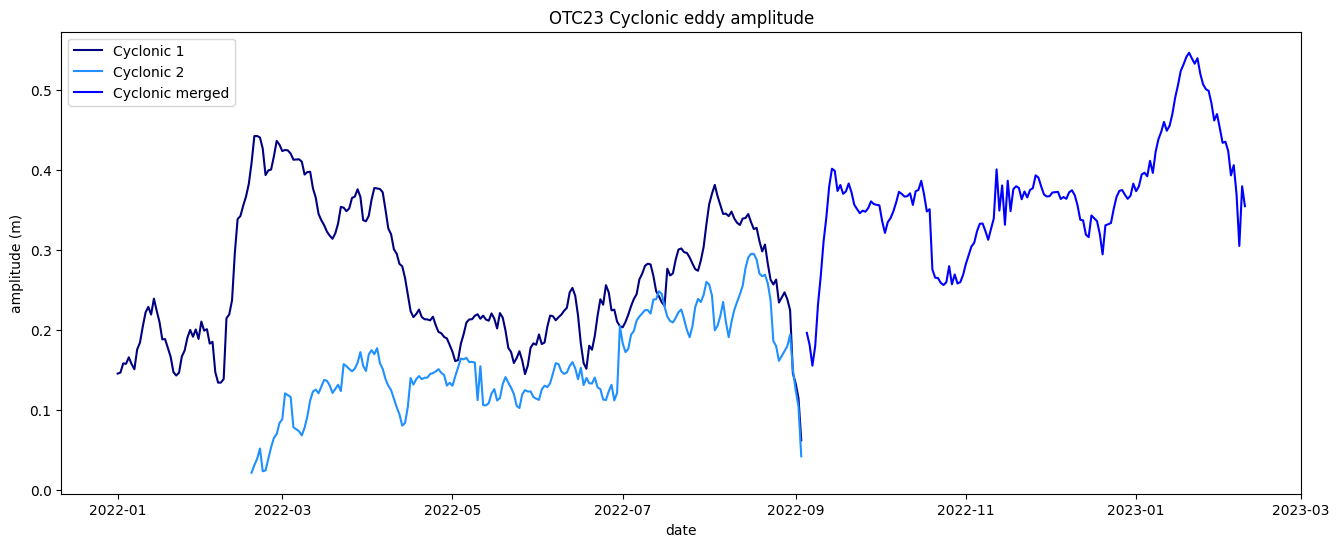

In [13]:
# Amplitude (in meter) 
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy amplitude')
ax.set_xlabel('date')
ax.set_ylabel('amplitude (m)')

ax.plot(to_datetime(c_eddy1_track.time), c_eddy1_track.amplitude, c='navy', label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), c_eddy2_track.amplitude, c='dodgerblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), c_mrged_track.amplitude, c='b', label='Cyclonic merged')

ax.legend()

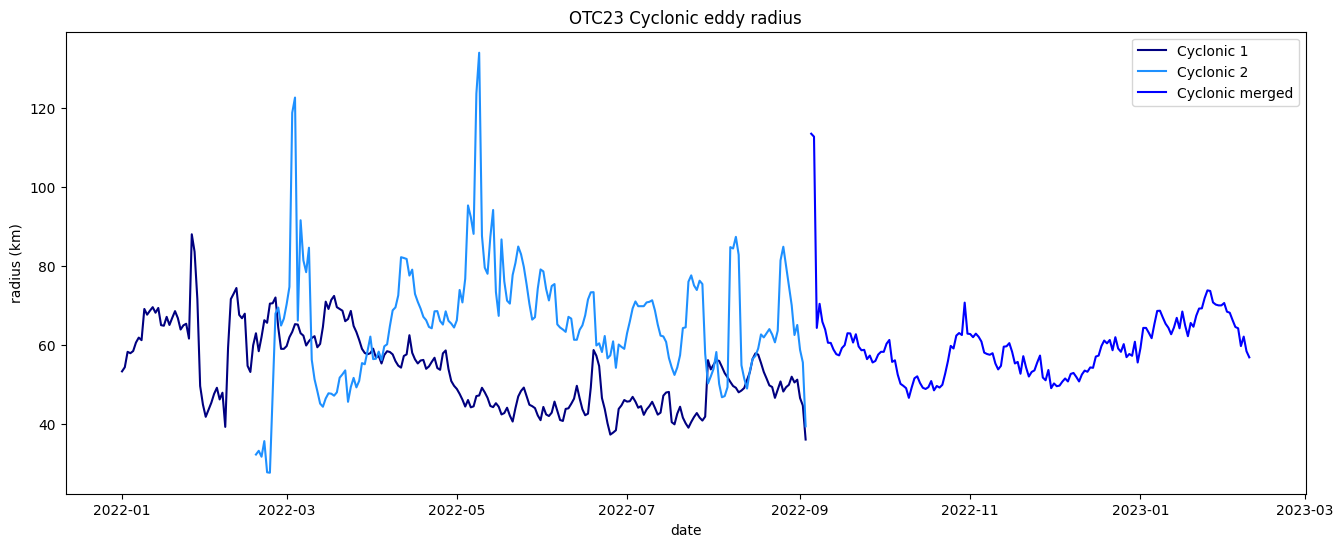

In [14]:
# Radius (in kilometer) 
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy radius')
ax.set_xlabel('date')
ax.set_ylabel('radius (km)')

ax.plot(to_datetime(c_eddy1_track.time), 1e-3*c_eddy1_track.speed_radius, c='navy', label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), 1e-3*c_eddy2_track.speed_radius, c='dodgerblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), 1e-3*c_mrged_track.speed_radius, c='b', label='Cyclonic merged')

ax.legend()

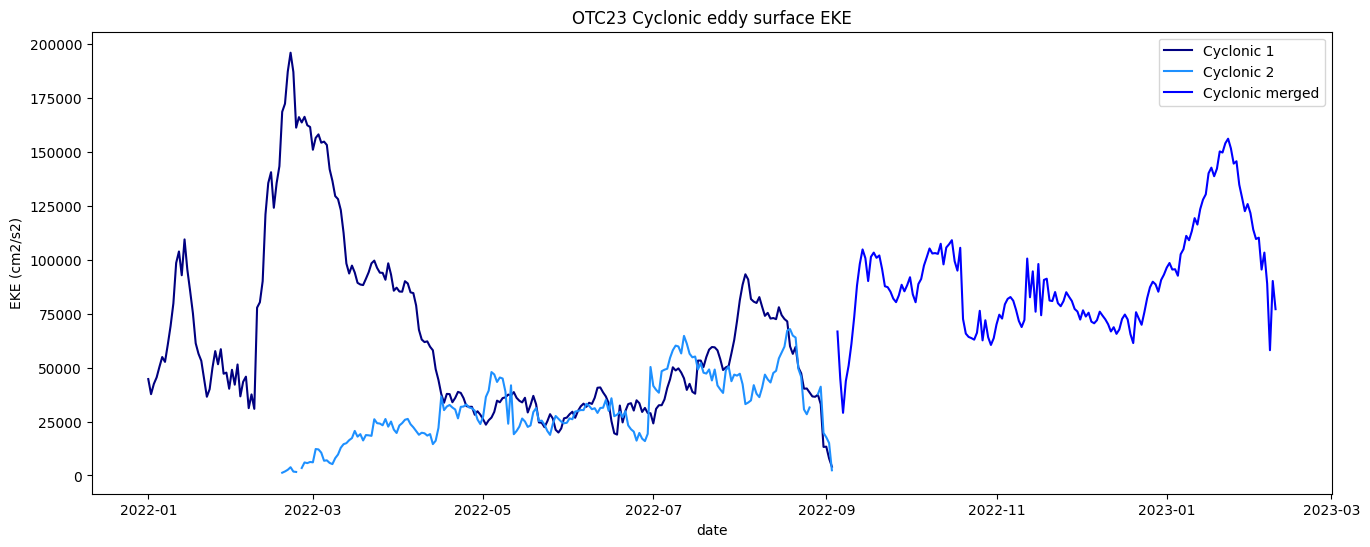

In [18]:
# EKE (in cm2/s2) 
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy surface EKE')
ax.set_xlabel('date')
ax.set_ylabel('EKE (cm2/s2)')

ax.plot(to_datetime(c_eddy1_track.time), 1e4*c_eddy1_track.eke, c='navy',       label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), 1e4*c_eddy2_track.eke, c='dodgerblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), 1e4*c_mrged_track.eke, c='b',     label='Cyclonic merged')

ax.legend()

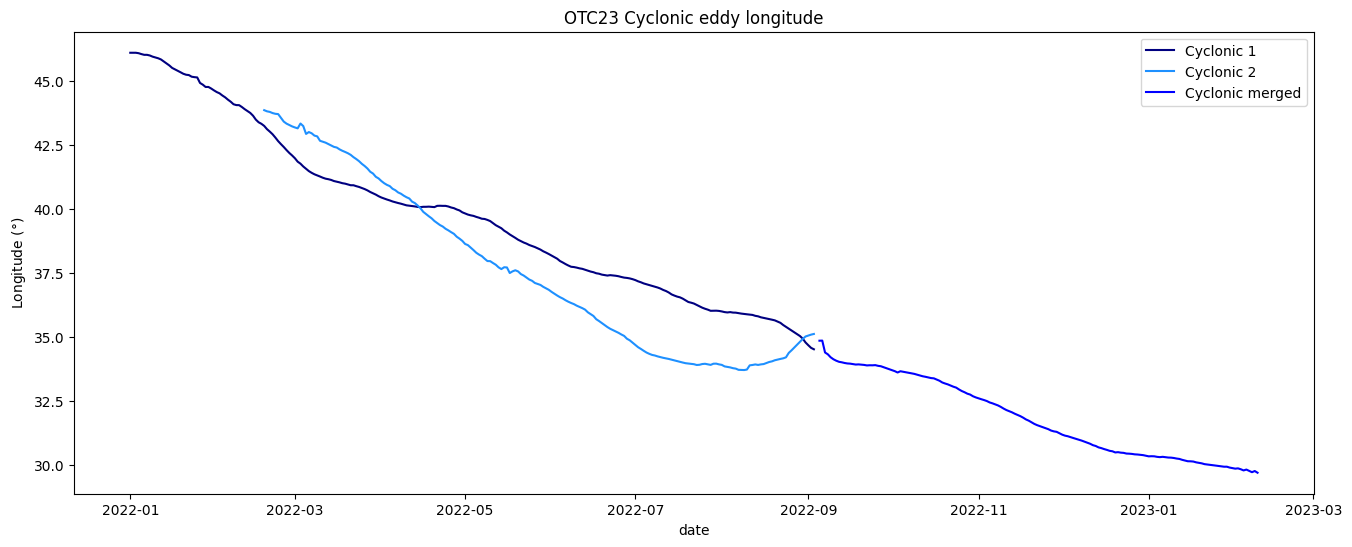

In [16]:
# Longitude (degree) 
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy longitude')
ax.set_xlabel('date')
ax.set_ylabel(r'Longitude ($\degree$)')

ax.plot(to_datetime(c_eddy1_track.time), c_eddy1_track.longitude, c='navy',       label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), c_eddy2_track.longitude, c='dodgerblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), c_mrged_track.longitude, c='b',     label='Cyclonic merged')

ax.legend()

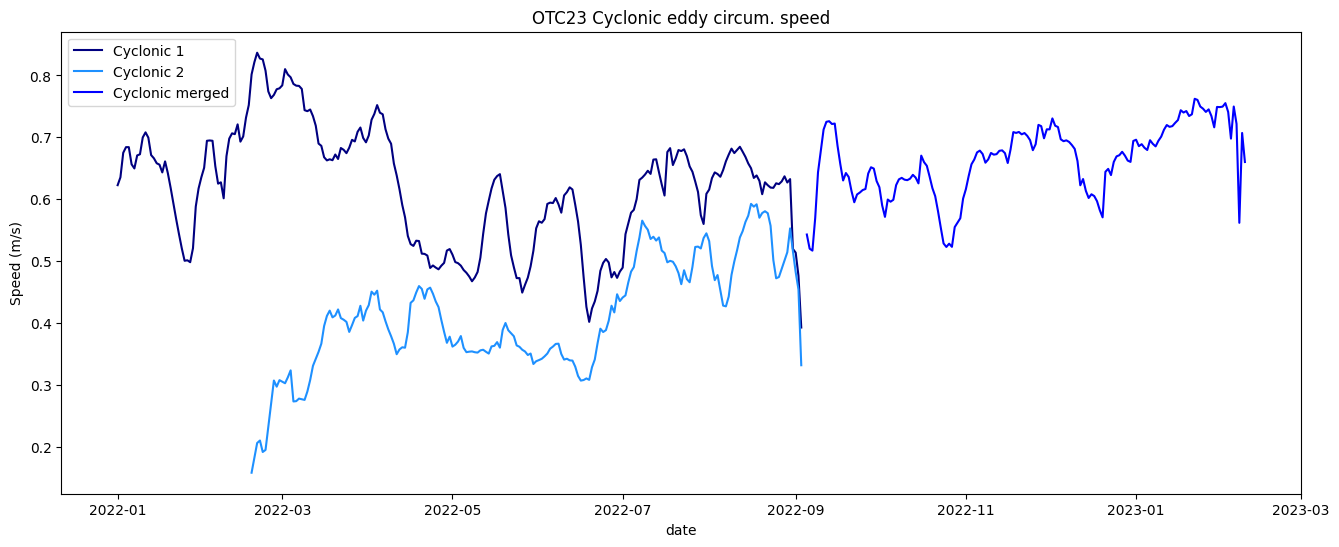

In [17]:
# Longitude (degree) 
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy circum. speed')
ax.set_xlabel('date')
ax.set_ylabel(r'Speed (m/s)')

ax.plot(to_datetime(c_eddy1_track.time), c_eddy1_track.speed_average, c='navy',       label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), c_eddy2_track.speed_average, c='dodgerblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), c_mrged_track.speed_average, c='b',     label='Cyclonic merged')

ax.legend()

## 2. Statistical analysis

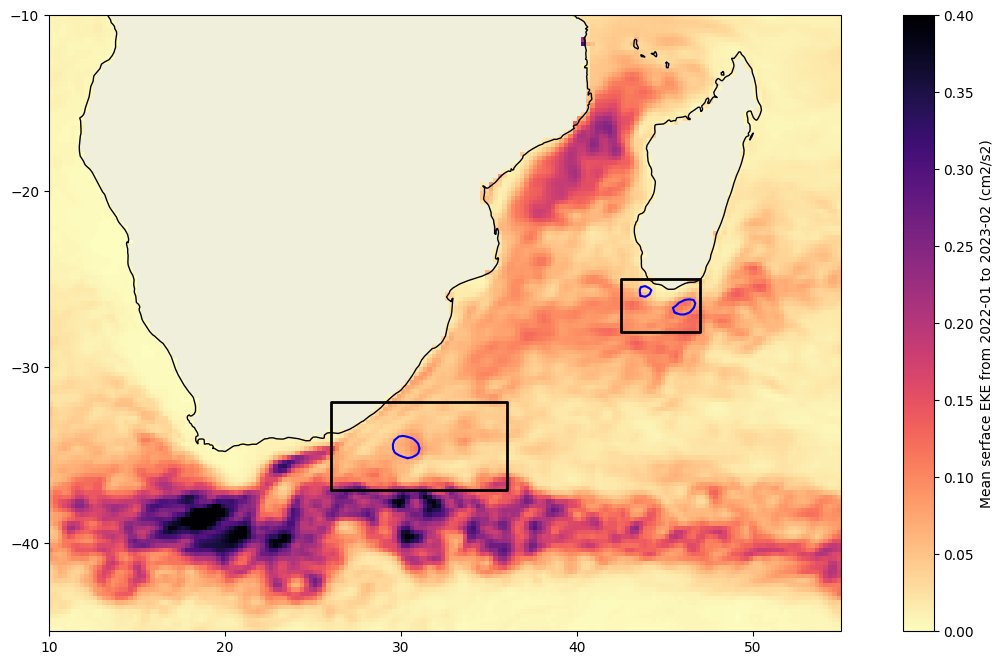

In [76]:
# Plot the eddy tracks
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([10, 55, -45, -10], crs=ccrs.PlateCarree())

# -- background image on for nice sea rendering
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

ax.set_xticks([10, 20, 30, 40, 50])
ax.set_yticks([-40, -30, -20, -10])

# -- add some eddy contour
#ax.plot(c_mrged_track.speed_contour_longitude[0], c_mrged_track.speed_contour_latitude[0], 'b')
ax.plot(c_mrged_track.speed_contour_longitude[-33], c_mrged_track.speed_contour_latitude[-33], 'b')
#ax.plot(c_mrged_track.speed_contour_longitude[-1], c_mrged_track.speed_contour_latitude[-1],  'b')

ax.plot(c_eddy1_track.speed_contour_longitude[0], c_eddy1_track.speed_contour_latitude[0], 'b')
ax.plot(c_eddy2_track.speed_contour_longitude[0], c_eddy2_track.speed_contour_latitude[0], 'b')


# -- add sea level anomaly colormesh
glon, glat = np.meshgrid(ds['longitude'], ds['latitude'])
m  = ax.pcolormesh(glon, glat, ds['eke'].mean('time'),  cmap='magma_r', vmin=0, vmax=0.4)
cb = fig.colorbar(m, ax=ax)
cb.set_label('Mean serface EKE from 2022-01 to 2023-02 (cm2/s2)')

# -- add contour box
box_agulhas = LinearRing([(26, -37), (36, -37), (36, -32), (26, -32)])
box_semc    = LinearRing([(42.5, -28), (47, -28), (47, -25), (42.5, -25)])

ax.add_geometries([box_agulhas, box_semc], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)

plt.show()